In [1]:
import pandas as pd
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as optim
import time
from agg_util import *
from fare.metrics import _count_inversions,_merge_parity
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle

In [2]:
n_ranks=20
rank_len=50

In [3]:
def loadData(filename):
    f = open(filename, 'rb')      
    d = pickle.load(f)  
    f.close() 

In [4]:
# once data has been processed load faster
# data = loadData("pre_post_data.pickle")

In [5]:
# read in data
methods = ["baseline","in_process","post_process","pre_process"]
data = pd.DataFrame(columns = ['theta','p','i','thresh','method','dist','parity'])
for theta in [0.3]:
#     print(theta)
    for p in [0.5, 0.7, 0.9]:
#         print(p)
        for itr in range(10):
            for thresh in [1]: #[612, 24, 1]:
                g = pd.read_csv("data/agg_base/groups"+str(p)+"_"+str(rank_len)+"_"+str(itr)+".txt",
                                             header=None).as_matrix().ravel()
                r = pd.read_csv("data/agg_res/output"+str(rank_len)+"_"+str(p)+"_"+str(theta)+"_"+str(thresh)+"_"+str(itr)+".txt",
                                             dtype=int, usecols=range(rank_len), header=None).as_matrix()
                base = pd.read_csv("data/agg_base/input"+str(rank_len)+"_"+str(theta)+"_"+str(itr)+".txt",dtype=int, 
                               usecols=range(rank_len), header=None).as_matrix()
                pre_process = pd.read_csv("data/agg_res/preprocess_output"+str(rank_len)+"_"+str(p)+"_"+str(theta)+"_"+str(thresh)+"_"+str(itr)+".txt",
                              dtype=int, usecols=range(rank_len), header=None).as_matrix()[0]
                
                baseline=r[0]
                in_process=r[1]
                post_process = np.array(correct_parity(baseline, g, thresh))
                for i,x in enumerate([baseline, in_process, post_process, pre_process]):
                    dist = 0
                    for b in base:
                        dist += kendalltau_dist(b, x)
                    dist /= n_ranks
                    e0,e1 = rank_parity(x, g)
                    parity = abs(e0-e1)
#                     parity /= int(rank_len/2)**2
                    data = data.append({
                        'theta':theta,
                        'p':p,
                        'i':i,
                        'thresh':thresh,
                        'method': methods[i],
                        'dist': dist,
                        'parity': parity}, ignore_index=True
                    )
            print(itr)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [6]:
data['parity'] = data['parity'].astype(int)
data.to_pickle("pre_post_data.pickle")

In [7]:
data.head()

,theta,p,i,thresh,method,dist,parity
0,0.3,0.5,0,1,baseline,122.1,293
1,0.3,0.5,1,1,in_process,205.0,1
2,0.3,0.5,2,1,post_process,232.0,1
3,0.3,0.5,3,1,pre_process,217.9,31
4,0.3,0.5,0,1,baseline,121.1,381


In [8]:
df = data[data['theta']==0.3][['method','p','dist','parity']]
df = df.groupby(['method','p']).mean()
df.reset_index()
# 
df['parity'] = df['parity'] / int(rank_len/2)**2
df
df.reset_index(inplace=True)

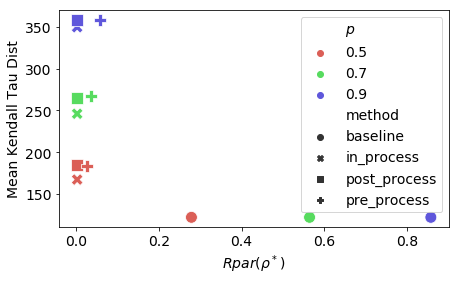

In [9]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (7,4)
cmap = sns.color_palette("hls", 3)
ax = sns.scatterplot(data=df, x='parity', y='dist', style='method', hue='p', legend="full", s=140, palette=cmap)
ax.set_ylabel("Mean Kendall Tau Dist")
ax.set_xlabel(r"$Rpar(\rho^*)$")
legend = ax.legend()
legend.texts[0].set_text(r"$p$")
fig = ax.get_figure()
# fig.savefig("pre_in_post.pdf", bbox_inches='tight') 

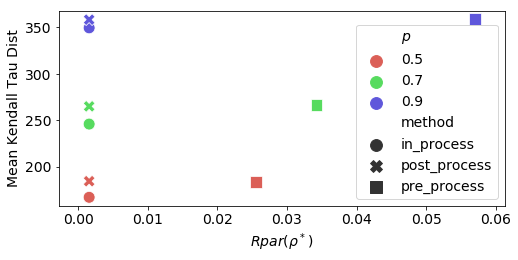

In [10]:
plt.rcParams["figure.figsize"] = (8,3.6)
ax =sns.scatterplot(data=df[df['method'] != 'baseline'], x='parity', y='dist', style='method', 
                hue='p', legend="full", s=140, palette=cmap)
ax.set_ylabel("Mean Kendall Tau Dist")
ax.set_xlabel(r"$Rpar(\rho^*)$")
legend = ax.legend()
legend.texts[0].set_text(r"$p$")
fig = ax.get_figure()
for lh in legend.legendHandles: 
    lh._sizes = [140] 
fig.savefig("pre_in_post_nob.pdf", bbox_inches='tight') 

In [11]:
df = data[data['p']==0.7][['method','theta','dist','parity']]
df = df.groupby(['method','theta']).mean()
df.reset_index(inplace=True)
